## P.S. The main idea behind this notebook is inspired from FabienDaniel Kernel Elo_world.
https://www.kaggle.com/fabiendaniel/elo-world

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc
import pickle
from sklearn.base import BaseEstimator
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import log_loss
from sklearn.model_selection import RepeatedKFold
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
%%time
# new_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/new_merchant_transactions.csv', parse_dates=['purchase_date'])
# historical_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv', parse_dates=['purchase_date'])

historical_transactions = pd.read_parquet('../input/hist_trans_df.parquet.gzip')
new_transactions = pd.read_parquet('../input/new_trans_df.parquet.gzip')

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [ ]:
feat_list = ['city_id', 'merchant_category_id', 'subsector_id']
for feat in feat_list:
    print(feat + ": " + str(len(historical_transactions[feat].unique())))

In [ ]:
# np.histogram(historical_transactions["city_id"], range=(0, historical_transactions["city_id"].max()), bins=historical_transactions["city_id"].max()+1)

plt.hist(x=historical_transactions["city_id"], bins='auto')
plt.show()

In [ ]:
print(historical_transactions["city_id"].value_counts())

In [ ]:
plt.hist(x=historical_transactions["merchant_category_id"], bins='auto')
plt.show()

In [ ]:
plt.hist(x=historical_transactions["subsector_id"], bins='auto')
plt.show()

In [ ]:
# %%time

# def encode_categorical_feat(df):
#     feat_list = ['city_id', 'merchant_category_id', 'subsector_id']
#     feat_list = ['city_id', 'subsector_id']
# #     feat_list = ['city_id']
#     for feat in feat_list:
#         df[feat + '_code'] = df[feat]
#     feat_list = [feat + '_code' for feat in feat_list]
#     for feat in feat_list:
#         encoder = ce.BinaryEncoder(cols=[feat])
#         df = encoder.fit_transform(df)
#     return df

# historical_transactions = encode_categorical_feat(historical_transactions)
# new_transactions = encode_categorical_feat(new_transactions)

In [ ]:
historical_transactions.head()

In [ ]:
# %%time

# def encode_categorical_feat_step2(df):
#     feat_list = ['city_id', 'merchant_category_id', 'subsector_id']
#     feat_list = ['merchant_category_id']
# #     feat_list = ['city_id']
#     for feat in feat_list:
#         df[feat + '_code'] = df[feat]
#     feat_list = [feat + '_code' for feat in feat_list]
#     for feat in feat_list:
#         encoder = ce.BinaryEncoder(cols=[feat])
#         df = encoder.fit_transform(df)
#     return df

# historical_transactions = encode_categorical_feat_step2(historical_transactions)
# new_transactions = encode_categorical_feat_step2(new_transactions)

In [ ]:
# %%time

# def encode_categorical_feat_step3(df):
# #     feat_list = ['city_id', 'merchant_category_id', 'subsector_id']
# #     feat_list = ['merchant_category_id']
# # #     feat_list = ['city_id']
# #     for feat in feat_list:
# #         df[feat + '_code'] = df[feat]
# #     feat_list = [feat + '_code' for feat in feat_list]
# #     for feat in feat_list:
# #         encoder = ce.BinaryEncoder(cols=[feat])
# #         df = encoder.fit_transform(df)
#     df = pd.get_dummies(df, columns=["merchant_category_id"])
#     return df

# historical_transactions = encode_categorical_feat_step3(historical_transactions)
# new_transactions = encode_categorical_feat_step3(new_transactions)

In [ ]:
def add_new_merch_feat(df, merch_df):
    df = pd.merge(left=df,
                  right=merch_df[['merchant_id', 'merchant_group_id', 'category_4']],
                  on=['merchant_id'],
                  how='left')
    df['year'] = df['purchase_date'].dt.year.astype('int8')
    df['month'] = df['purchase_date'].dt.month.astype('int8')
    df['dow'] = df['purchase_date'].dt.dayofweek.astype('int8')
    df['hour'] = df['purchase_date'].dt.hour.astype('int8')
    df['day_part'] = 'Morning'
    df.loc[(df['hour'] > 12) & (df['hour'] <= 18), 'day_part'] = 'Afternoon'
    df.loc[(df['hour'] > 18) & (df['hour'] <= 24), 'day_part'] = 'Evening'
    # df['installments_flag'] = np.where(df['installments'] > 1, 'Y', 'N')
    
    # convert into proper data types
#     df['hour'] = df['hour'].astype('category')
#     df['day_part'] = df['day_part'].astype('category')
    # df['installments_flag'] = hist_trans_df['installments_flag'].astype('category')
    # df['dummy'] = 1
    # df.head(5)
    
    return df

In [ ]:
%%time
merch_df = pd.read_parquet('../input/merch_df.parquet.gzip')

historical_transactions = add_new_merch_feat(historical_transactions, merch_df)
new_transactions = add_new_merch_feat(new_transactions, merch_df)

del merch_df
gc.collect()

In [ ]:
historical_transactions.head()

In [ ]:
%%time
# def read_data(input_file):
#     df = pd.read_csv(input_file)
#     df['first_active_month'] = pd.to_datetime(df['first_active_month'])
#     df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
#     return df

# train = read_data('../input/elo-merchant-category-recommendation/train.csv')
# test = read_data('../input/elo-merchant-category-recommendation/test.csv')

def read_data_v2(input_file):
    df = pd.read_parquet(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data_v2('../input/train_df.parquet.gzip')
test = read_data_v2('../input/test_df.parquet.gzip')

target = train['target']
del train['target']
gc.collect()

## **Feature Engineering**

In [ ]:
plot_opt = 1

In [ ]:
historical_transactions["category_1"] += 1
historical_transactions["category_1"].unique()

In [ ]:
new_transactions["category_1"] += 1
new_transactions["category_1"].unique()

In [ ]:
historical_transactions["category_2"].unique()

In [ ]:
historical_transactions["category_2"] = historical_transactions["category_2"].fillna(0)
historical_transactions["category_2"].unique()

In [ ]:
new_transactions["category_2"].unique()

In [ ]:
new_transactions["category_2"] = new_transactions["category_2"].fillna(0)
new_transactions["category_2"].unique()

In [ ]:
historical_transactions["category_3"].unique()

In [ ]:
historical_transactions["category_3"] = historical_transactions["category_3"].replace({'A': 1, 'B': 2, 'C': 3, None: 0})
historical_transactions["category_3"].unique()

In [ ]:
new_transactions["category_3"].unique()

In [ ]:
new_transactions["category_3"] = new_transactions["category_3"].replace({'A': 1, 'B': 2, 'C': 3, None: 0})
new_transactions["category_3"].unique()

In [ ]:
historical_transactions["category_4"].unique()

In [ ]:
historical_transactions["category_4"] = historical_transactions["category_4"].fillna(0)
historical_transactions["category_4"] = historical_transactions["category_4"].replace({'Y': 1, 'N': 2})
historical_transactions["category_4"].unique()

In [ ]:
new_transactions["category_4"].unique()

In [ ]:
new_transactions["category_4"] = new_transactions["category_4"].fillna(0)
new_transactions["category_4"] = new_transactions["category_4"].replace({'Y': 1, 'N': 2})
new_transactions["category_4"].unique()

#### feature cross: category_1, category_2

In [ ]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions.at["category_1"], historical_transactions["category_2"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_2")
#     plt.show()

In [ ]:
# historical_transactions["category_1_2_cross"] = historical_transactions["category_1"]*2 + historical_transactions["category_2"]
# np.sort(historical_transactions["category_1_2_cross"].unique())

In [ ]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_1"], new_transactions["category_2"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_2")
#     plt.show()

In [ ]:
# new_transactions["category_1_2_cross"] = new_transactions["category_1"]*2 + new_transactions["category_2"]
# np.sort(new_transactions["category_1_2_cross"].unique())

#### feature cross: category_1, category_3

In [ ]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions["category_1"], historical_transactions["category_3"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_3")
#     plt.show()

In [ ]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions["category_1"]+2, historical_transactions["category_3"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_3")
#     plt.show()

In [ ]:
# historical_transactions["category_1_3_cross"] = (historical_transactions["category_1"]+2) * historical_transactions["category_3"]
# np.sort(historical_transactions["category_1_3_cross"].unique())

In [ ]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_1"], new_transactions["category_3"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_3")
#     plt.show()

In [ ]:
# new_transactions["category_1_3_cross"] = (new_transactions["category_1"]+2) * new_transactions["category_3"]
# np.sort(new_transactions["category_1_3_cross"].unique())

#### feature cross: category_2, category_3

In [ ]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions["category_2"], historical_transactions["category_3"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_2")
#     plt.show()

In [ ]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions["category_2"]+6, historical_transactions["category_3"])
#     plt.xlabel("category_2")
#     plt.ylabel("category_3")
#     plt.show()

In [ ]:
# historical_transactions["category_2_3_cross"] = (historical_transactions["category_2"]+6) * historical_transactions["category_3"]
# np.sort(historical_transactions["category_2_3_cross"].unique())

In [ ]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_2"]+6, new_transactions["category_3"])
#     plt.xlabel("category_2")
#     plt.ylabel("category_3")
#     plt.show()

In [ ]:
# new_transactions["category_2_3_cross"] = (new_transactions["category_2"]+6) * new_transactions["category_3"]
# np.sort(new_transactions["category_2_3_cross"].unique())

#### feature cross: category_1, category_4

In [ ]:
# %%time
# if plot_opt:
#     temp = historical_transactions[[0:10000]]
#     plt.scatter(temp["category_1"], temp["category_4"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_4")
#     plt.show()

In [ ]:
%%time
if plot_opt:
    plt.scatter(new_transactions["category_1"]+2, new_transactions["category_4"])
    plt.xlabel("category_1")
    plt.ylabel("category_4")
    plt.show()

In [ ]:
# historical_transactions["category_1_4_cross"] = (historical_transactions["category_1"]+2) * historical_transactions["category_4"]
# np.sort(historical_transactions["category_1_4_cross"].unique())

In [ ]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_1"]+2, new_transactions["category_4"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_4")
#     plt.show()

In [ ]:
# new_transactions["category_1_4_cross"] = (new_transactions["category_1"]+2) * new_transactions["category_4"]
# np.sort(new_transactions["category_1_4_cross"].unique())

#### feature cross: category_2, category_4

In [ ]:
%%time
if plot_opt:
    plt.scatter(new_transactions["category_2"]+6, new_transactions["category_4"])
    plt.xlabel("category_2")
    plt.ylabel("category_4")
    plt.show()

In [ ]:
historical_transactions["category_2_4_cross"] = (historical_transactions["category_2"]+6) * historical_transactions["category_4"]
np.sort(historical_transactions["category_2_4_cross"].unique())

In [ ]:
new_transactions["category_2_4_cross"] = (new_transactions["category_2"]+6) * new_transactions["category_4"]
np.sort(new_transactions["category_2_4_cross"].unique())

In [ ]:
historical_transactions.head()

#### feature cross: category_3, category_4

In [ ]:
%%time
if plot_opt:
    plt.scatter(new_transactions["category_3"], new_transactions["category_4"])
    plt.xlabel("category_3")
    plt.ylabel("category_4")
    plt.show()

In [ ]:
%%time
if plot_opt:
    plt.scatter(new_transactions["category_3"]+4, new_transactions["category_4"])
    plt.xlabel("category_3")
    plt.ylabel("category_4")
    plt.show()

In [ ]:
# historical_transactions["category_3_4_cross"] = (historical_transactions["category_3"]+4) * historical_transactions["category_4"]
# np.sort(historical_transactions["category_3_4_cross"].unique())

#### generate the above feature cross features

In [ ]:
%%time

def category_make_cross_feat(df):
    df["category_1_3_cross"] = (df["category_1"]+2) * df["category_3"]
    df["category_2_3_cross"] = (df["category_2"]+6) * df["category_3"]
    df["category_1_4_cross"] = (df["category_1"]+2) * df["category_4"]
    df["category_2_4_cross"] = (df["category_2"]+6) * df["category_4"]
    df["category_3_4_cross"] = (df["category_3"]+4) * df["category_4"]
    return df

historical_transactions = category_make_cross_feat(historical_transactions)
new_transactions = category_make_cross_feat(new_transactions)

In [ ]:
historical_transactions.head()

In [ ]:
# feat_list = ['city_id', 'merchant_category_id', 'subsector_id']
# for feat in feat_list:
#     print(feat + ": " + str(len(historical_transactions[feat].unique())))
type(historical_transactions['year'][0])

In [ ]:
%%time

def preprocessing(df):
    df = pd.get_dummies(df, columns=['category_2',
                                     'category_3',
                                     'category_4',
                                     'category_1_3_cross',
                                     'category_2_3_cross',
                                     'category_1_4_cross',
                                     'category_2_4_cross',
                                     'category_3_4_cross',
#                                      'year',
                                     'month',
                                     'dow',
                                     'hour',
                                     'day_part',
#                                      'subsector_id'
                                     ])
#     feat_list = ['year', 'month', 'dow', 'hour', 'day_part']
# #     feat_list = ['city_id']
#     for feat in feat_list:
#         df[feat + '_code'] = df[feat]
#     feat_list = [feat + '_code' for feat in feat_list]
#     for feat in feat_list:
#         encoder = ce.BinaryEncoder(cols=[feat])
#         df = encoder.fit_transform(df)
#     df["month_code"] = df["month"]
#     encoder = ce.BinaryEncoder(cols=["month_code"])
#     df = encoder.fit_transform(df)
#     df = reduce_mem_usage(df)
    
    return df
    
historical_transactions = preprocessing(historical_transactions)
new_transactions = preprocessing(new_transactions)



In [ ]:
agg_fun = {'authorized_flag': ['sum', 'mean', 'min', 'std', 'count']} # max is all 1's, useless
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]
gc.collect()

In [ ]:
historical_transactions.head()

In [ ]:
historical_transactions.dtypes

In [ ]:

# feat_list = list(new_transactions)
# for feat in feat_list:
#     if 'city_id_' in feat or 'year_' in feat or 'dow_' in feat or 'month_' in feat or 'day_part_' in feat or 'cross_' in feat:
# #         print('hi')
#         new_transactions[feat]= new_transactions[feat].astype('bool')

In [ ]:
%%time
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month
gc.collect()

In [ ]:
new_transactions.head()

In [ ]:
count = 0
for feat in list(historical_transactions):
    if 'merchant_category_id_' in feat:
        count += 1
print(count)

In [ ]:
count = 0
for feat in list(new_transactions):
    if 'merchant_category_id_' in feat:
        count += 1
print(count)

In [ ]:
count = 0
for feat in list(authorized_transactions):
    if 'merchant_category_id_' in feat:
        count += 1
print(count)

In [ ]:
# authorized_transactions = encode_categorical_feat_step3(authorized_transactions)

In [ ]:
# %%time

# def encode_categorical_feat_step3(df):
# #     feat_list = ['city_id', 'merchant_category_id', 'subsector_id']
# #     feat_list = ['merchant_category_id']
# # #     feat_list = ['city_id']
# #     for feat in feat_list:
# #         df[feat + '_code'] = df[feat]
# #     feat_list = [feat + '_code' for feat in feat_list]
# #     for feat in feat_list:
# #         encoder = ce.BinaryEncoder(cols=[feat])
# #         df = encoder.fit_transform(df)
#     df = pd.get_dummies(df, columns=["merchant_category_id"])
#     return df

# historical_transactions = encode_categorical_feat_step3(historical_transactions)
# new_transactions = encode_categorical_feat_step3(new_transactions)
# authorized_transactions = encode_categorical_feat_step3(authorized_transactions)

In [ ]:
%%time
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_1': ['mean'],
        'category_3_2': ['mean'],
        'category_3_3': ['mean'],
        'category_4_111111': ['mean'],
        'category_1_3_cross_3': ['mean'],
        'category_1_3_cross_4': ['mean'],
        'category_1_3_cross_6': ['mean'],
        'category_1_3_cross_8': ['mean'],
        'category_1_3_cross_9': ['mean'],
        'category_1_3_cross_12': ['mean'],
        'category_2_3_cross_7.0': ['mean'],
        'category_2_3_cross_8.0': ['mean'],
        'category_2_3_cross_9.0': ['mean'],
        'category_2_3_cross_10.0': ['mean'],
        'category_2_3_cross_11.0': ['mean'],
        'category_2_3_cross_12.0': ['mean'],
        'category_2_3_cross_14.0': ['mean'],
        'category_2_3_cross_16.0': ['mean'],
        'category_2_3_cross_20.0': ['mean'],
        'category_2_3_cross_21.0': ['mean'],
        'category_2_3_cross_22.0': ['mean'],
        'category_2_3_cross_24.0': ['mean'],
        'category_2_3_cross_27.0': ['mean'],
        'category_2_3_cross_30.0': ['mean'],
        'category_2_3_cross_33.0': ['mean'],
        'category_1_4_cross_3': ['mean'],
        'category_1_4_cross_4': ['mean'],
        'category_1_4_cross_6': ['mean'],
        'category_1_4_cross_8': ['mean'],
        'category_2_4_cross_7.0': ['mean'],
        'category_2_4_cross_8.0': ['mean'],
        'category_2_4_cross_9.0': ['mean'],
        'category_2_4_cross_10.0': ['mean'],
        'category_2_4_cross_11.0': ['mean'],
        'category_2_4_cross_14.0': ['mean'],
        'category_2_4_cross_16.0': ['mean'],
        'category_2_4_cross_18.0': ['mean'],
        'category_2_4_cross_20.0': ['mean'],
        'category_2_4_cross_22.0': ['mean'],
        'category_3_4_cross_5': ['mean'],
        'category_3_4_cross_6': ['mean'],
        'category_3_4_cross_7': ['mean'],
        'category_3_4_cross_10': ['mean'],
        'category_3_4_cross_12': ['mean'],
        'category_3_4_cross_14': ['mean'],
#         'merchant_category_id_2': ['mean'],
#         'merchant_category_id_9': ['mean'],
#         'merchant_category_id_11': ['mean'],
#         'merchant_category_id_14': ['mean'],
#         'merchant_category_id_16': ['mean'],
#         'merchant_category_id_18': ['mean'],
#         'merchant_category_id_19': ['mean'],
#         'merchant_category_id_21': ['mean'],
#         'merchant_category_id_27': ['mean'],
#         'merchant_category_id_31': ['mean'],
#         'merchant_category_id_33': ['mean'],
#         'merchant_category_id_34': ['mean'],
#         'merchant_category_id_36': ['mean'],
#         'merchant_category_id_38': ['mean'],
#         'merchant_category_id_40': ['mean'],
#         'merchant_category_id_45': ['mean'],
#         'merchant_category_id_49': ['mean'],
#         'merchant_category_id_52': ['mean'],
#         'merchant_category_id_53': ['mean'],
#         'merchant_category_id_56': ['mean'],
#         'merchant_category_id_57': ['mean'],
#         #'merchant_category_id_59': ['mean'],
#         'merchant_category_id_60': ['mean'],
#         'merchant_category_id_63': ['mean'],
#         'merchant_category_id_68': ['mean'],
#         'merchant_category_id_69': ['mean'],
#         'merchant_category_id_71': ['mean'],
#         'merchant_category_id_78': ['mean'],
#         'merchant_category_id_80': ['mean'],
#         'merchant_category_id_81': ['mean'],
#         'merchant_category_id_83': ['mean'],
#         'merchant_category_id_87': ['mean'],
#         'merchant_category_id_90': ['mean'],
#         'merchant_category_id_101': ['mean'],
#         'merchant_category_id_105': ['mean'],
#         'merchant_category_id_108': ['mean'],
#         'merchant_category_id_109': ['mean'],
#         'merchant_category_id_110': ['mean'],
#         'merchant_category_id_111': ['mean'],
#         'merchant_category_id_114': ['mean'],
#         'merchant_category_id_115': ['mean'],
#         'merchant_category_id_117': ['mean'],
#         'merchant_category_id_119': ['mean'],
#         'merchant_category_id_126': ['mean'],
#         'merchant_category_id_130': ['mean'],
#         'merchant_category_id_131': ['mean'],
#         'merchant_category_id_140': ['mean'],
#         'merchant_category_id_141': ['mean'],
#         'merchant_category_id_145': ['mean'],
#         'merchant_category_id_153': ['mean'],
#         'merchant_category_id_154': ['mean'],
#         'merchant_category_id_157': ['mean'],
#         'merchant_category_id_162': ['mean'],
#         'merchant_category_id_166': ['mean'],
#         'merchant_category_id_171': ['mean'],
#         'merchant_category_id_172': ['mean'],
#         'merchant_category_id_178': ['mean'],
#         'merchant_category_id_179': ['mean'],
#         'merchant_category_id_180': ['mean'],
#         'merchant_category_id_181': ['mean'],
#         'merchant_category_id_182': ['mean'],
#         'merchant_category_id_183': ['mean'],
#         'merchant_category_id_184': ['mean'],
#         'merchant_category_id_187': ['mean'],
#         'merchant_category_id_190': ['mean'],
#         'merchant_category_id_192': ['mean'],
#         'merchant_category_id_195': ['mean'],
#         'merchant_category_id_198': ['mean'],
#         'merchant_category_id_201': ['mean'],
#         'merchant_category_id_206': ['mean'],
#         'merchant_category_id_209': ['mean'],
#         'merchant_category_id_210': ['mean'],
#         'merchant_category_id_215': ['mean'],
#         'merchant_category_id_216': ['mean'],
#         'merchant_category_id_217': ['mean'],
#         'merchant_category_id_222': ['mean'],
#         'merchant_category_id_223': ['mean'],
#         'merchant_category_id_224': ['mean'],
#         'merchant_category_id_225': ['mean'],
#         'merchant_category_id_241': ['mean'],
#         'merchant_category_id_245': ['mean'],
#         'merchant_category_id_246': ['mean'],
#         'merchant_category_id_247': ['mean'],
#         'merchant_category_id_248': ['mean'],
#         'merchant_category_id_249': ['mean'],
#         'merchant_category_id_259': ['mean'],
#         'merchant_category_id_260': ['mean'],
#         'merchant_category_id_261': ['mean'],
#         'merchant_category_id_265': ['mean'],
#         'merchant_category_id_266': ['mean'],
#         'merchant_category_id_267': ['mean'],
#         'merchant_category_id_268': ['mean'],
#         'merchant_category_id_273': ['mean'],
#         'merchant_category_id_274': ['mean'],
#         'merchant_category_id_276': ['mean'],
#         'merchant_category_id_278': ['mean'],
#         'merchant_category_id_289': ['mean'],
#         'merchant_category_id_290': ['mean'],
#         'merchant_category_id_292': ['mean'],
#         'merchant_category_id_298': ['mean'],
#         'merchant_category_id_299': ['mean'],
#         'merchant_category_id_302': ['mean'],
#         'merchant_category_id_307': ['mean'],
#         'merchant_category_id_309': ['mean'],
#         'merchant_category_id_312': ['mean'],
#         'merchant_category_id_315': ['mean'],
#         'merchant_category_id_317': ['mean'],
#         'merchant_category_id_319': ['mean'],
#         'merchant_category_id_320': ['mean'],
#         'merchant_category_id_330': ['mean'],
#         'merchant_category_id_332': ['mean'],
#         'merchant_category_id_333': ['mean'],
#         'merchant_category_id_334': ['mean'],
#         'merchant_category_id_340': ['mean'],
#         'merchant_category_id_342': ['mean'],
#         'merchant_category_id_343': ['mean'],
#         'merchant_category_id_345': ['mean'],
#         'merchant_category_id_348': ['mean'],
#         'merchant_category_id_351': ['mean'],
#         'merchant_category_id_355': ['mean'],
#         'merchant_category_id_356': ['mean'],
#         'merchant_category_id_357': ['mean'],
#         'merchant_category_id_358': ['mean'],
#         'merchant_category_id_360': ['mean'],
#         'merchant_category_id_363': ['mean'],
#         'merchant_category_id_367': ['mean'],
#         'merchant_category_id_369': ['mean'],
#         'merchant_category_id_373': ['mean'],
#         'merchant_category_id_374': ['mean'],
#         'merchant_category_id_381': ['mean'],
#         'merchant_category_id_383': ['mean'],
#         'merchant_category_id_384': ['mean'],
#         'merchant_category_id_385': ['mean'],
#         'merchant_category_id_386': ['mean'],
#         'merchant_category_id_387': ['mean'],
#         'merchant_category_id_391': ['mean'],
#         'merchant_category_id_393': ['mean'],
#         'merchant_category_id_396': ['mean'],
#         'merchant_category_id_398': ['mean'],
#         'merchant_category_id_400': ['mean'],
#         'merchant_category_id_401': ['mean'],
#         'merchant_category_id_409': ['mean'],
#         'merchant_category_id_411': ['mean'],
#         'merchant_category_id_412': ['mean'],
#         'merchant_category_id_414': ['mean'],
#         'merchant_category_id_415': ['mean'],
#         'merchant_category_id_416': ['mean'],
#         'merchant_category_id_417': ['mean'],
#         'merchant_category_id_419': ['mean'],
#         'merchant_category_id_420': ['mean'],
#         'merchant_category_id_421': ['mean'],
#         'merchant_category_id_422': ['mean'],
#         'merchant_category_id_427': ['mean'],
#         'merchant_category_id_430': ['mean'],
#         'merchant_category_id_432': ['mean'],
#         'merchant_category_id_434': ['mean'],
#         'merchant_category_id_436': ['mean'],
#         'merchant_category_id_437': ['mean'],
#         'merchant_category_id_438': ['mean'],
#         'merchant_category_id_443': ['mean'],
#         'merchant_category_id_448': ['mean'],
#         'merchant_category_id_451': ['mean'],
#         'merchant_category_id_454': ['mean'],
#         'merchant_category_id_456': ['mean'],
#         'merchant_category_id_457': ['mean'],
#         'merchant_category_id_458': ['mean'],
#         'merchant_category_id_462': ['mean'],
#         'merchant_category_id_464': ['mean'],
#         'merchant_category_id_469': ['mean'],
#         'merchant_category_id_471': ['mean'],
#         'merchant_category_id_472': ['mean'],
#         'merchant_category_id_474': ['mean'],
#         'merchant_category_id_478': ['mean'],
#         'merchant_category_id_480': ['mean'],
#         'merchant_category_id_482': ['mean'],
#         'merchant_category_id_489': ['mean'],
#         'merchant_category_id_491': ['mean'],
#         'merchant_category_id_497': ['mean'],
#         'merchant_category_id_498': ['mean'],
#         'merchant_category_id_499': ['mean'],
#         'merchant_category_id_504': ['mean'],
#         'merchant_category_id_506': ['mean'],
#         'merchant_category_id_507': ['mean'],
#         'merchant_category_id_509': ['mean'],
#         'merchant_category_id_511': ['mean'],
#         'merchant_category_id_513': ['mean'],
#         'merchant_category_id_514': ['mean'],
#         'merchant_category_id_518': ['mean'],
#         'merchant_category_id_519': ['mean'],
#         'merchant_category_id_523': ['mean'],
#         'merchant_category_id_526': ['mean'],
#         'merchant_category_id_527': ['mean'],
#         'merchant_category_id_528': ['mean'],
#         'merchant_category_id_529': ['mean'],
#         'merchant_category_id_530': ['mean'],
#         'merchant_category_id_531': ['mean'],
#         'merchant_category_id_534': ['mean'],
#         'merchant_category_id_536': ['mean'],
#         'merchant_category_id_542': ['mean'],
#         'merchant_category_id_544': ['mean'],
#         'merchant_category_id_546': ['mean'],
#         'merchant_category_id_550': ['mean'],
#         'merchant_category_id_551': ['mean'],
#         'merchant_category_id_554': ['mean'],
#         'merchant_category_id_556': ['mean'],
#         'merchant_category_id_557': ['mean'],
#         'merchant_category_id_560': ['mean'],
#         'merchant_category_id_561': ['mean'],
#         'merchant_category_id_568': ['mean'],
#         'merchant_category_id_573': ['mean'],
#         'merchant_category_id_574': ['mean'],
#         'merchant_category_id_580': ['mean'],
#         'merchant_category_id_583': ['mean'],
#         'merchant_category_id_591': ['mean'],
#         'merchant_category_id_593': ['mean'],
#         'merchant_category_id_598': ['mean'],
#         'merchant_category_id_599': ['mean'],
#         'merchant_category_id_605': ['mean'],
#         'merchant_category_id_606': ['mean'],
#         'merchant_category_id_607': ['mean'],
#         'merchant_category_id_613': ['mean'],
#         'merchant_category_id_614': ['mean'],
#         'merchant_category_id_623': ['mean'],
#         'merchant_category_id_628': ['mean'],
#         'merchant_category_id_630': ['mean'],
#         'merchant_category_id_631': ['mean'],
#         'merchant_category_id_637': ['mean'],
#         'merchant_category_id_642': ['mean'],
#         'merchant_category_id_645': ['mean'],
#         'merchant_category_id_648': ['mean'],
#         'merchant_category_id_650': ['mean'],
#         'merchant_category_id_651': ['mean'],
#         'merchant_category_id_652': ['mean'],
#         'merchant_category_id_653': ['mean'],
#         'merchant_category_id_656': ['mean'],
#         'merchant_category_id_661': ['mean'],
#         'merchant_category_id_662': ['mean'],
#         'merchant_category_id_664': ['mean'],
#         'merchant_category_id_665': ['mean'],
#         'merchant_category_id_667': ['mean'],
#         'merchant_category_id_668': ['mean'],
#         'merchant_category_id_669': ['mean'],
#         'merchant_category_id_670': ['mean'],
#         'merchant_category_id_671': ['mean'],
#         'merchant_category_id_676': ['mean'],
#         'merchant_category_id_683': ['mean'],
#         'merchant_category_id_685': ['mean'],
#         'merchant_category_id_686': ['mean'],
#         'merchant_category_id_690': ['mean'],
#         'merchant_category_id_692': ['mean'],
#         'merchant_category_id_695': ['mean'],
#         'merchant_category_id_696': ['mean'],
#         'merchant_category_id_702': ['mean'],
#         'merchant_category_id_703': ['mean'],
#         'merchant_category_id_705': ['mean'],
#         'merchant_category_id_706': ['mean'],
#         'merchant_category_id_712': ['mean'],
#         'merchant_category_id_713': ['mean'],
#         'merchant_category_id_714': ['mean'],
#         'merchant_category_id_717': ['mean'],
#         'merchant_category_id_718': ['mean'],
#         'merchant_category_id_734': ['mean'],
#         'merchant_category_id_737': ['mean'],
#         'merchant_category_id_741': ['mean'],
#         'merchant_category_id_743': ['mean'],
#         'merchant_category_id_748': ['mean'],
#         'merchant_category_id_751': ['mean'],
#         'merchant_category_id_755': ['mean'],
#         'merchant_category_id_757': ['mean'],
#         'merchant_category_id_761': ['mean'],
#         'merchant_category_id_763': ['mean'],
#         'merchant_category_id_769': ['mean'],
#         'merchant_category_id_771': ['mean'],
#         'merchant_category_id_774': ['mean'],
#         'merchant_category_id_779': ['mean'],
#         'merchant_category_id_780': ['mean'],
#         'merchant_category_id_781': ['mean'],
#         'merchant_category_id_783': ['mean'],
#         'merchant_category_id_790': ['mean'],
#         'merchant_category_id_792': ['mean'],
#         'merchant_category_id_793': ['mean'],
#         'merchant_category_id_795': ['mean'],
#         'merchant_category_id_796': ['mean'],
#         'merchant_category_id_803': ['mean'],
#         'merchant_category_id_806': ['mean'],
#         'merchant_category_id_808': ['mean'],
#         'merchant_category_id_813': ['mean'],
#         'merchant_category_id_814': ['mean'],
#         'merchant_category_id_817': ['mean'],
#         'merchant_category_id_818': ['mean'],
#         'merchant_category_id_819': ['mean'],
#         'merchant_category_id_823': ['mean'],
#         'merchant_category_id_827': ['mean'],
#         'merchant_category_id_829': ['mean'],
#         'merchant_category_id_834': ['mean'],
#         'merchant_category_id_836': ['mean'],
#         'merchant_category_id_839': ['mean'],
#         'merchant_category_id_840': ['mean'],
#         'merchant_category_id_842': ['mean'],
#         'merchant_category_id_843': ['mean'],
#         'merchant_category_id_847': ['mean'],
#         'merchant_category_id_854': ['mean'],
#         'merchant_category_id_873': ['mean'],
#         'merchant_category_id_878': ['mean'],
#         'merchant_category_id_879': ['mean'],
#         'merchant_category_id_881': ['mean'],
#         'merchant_category_id_884': ['mean'],
#         'merchant_category_id_885': ['mean'],
#         'merchant_category_id_889': ['mean'],
#         'merchant_category_id_891': ['mean'],
#         'merchant_category_id_code_0': ['mean'],
#         'merchant_category_id_code_1': ['mean'],
#         'merchant_category_id_code_2': ['mean'],
#         'merchant_category_id_code_3': ['mean'],
#         'merchant_category_id_code_4': ['mean'],
#         'merchant_category_id_code_5': ['mean'],
#         'merchant_category_id_code_6': ['mean'],
#         'merchant_category_id_code_7': ['mean'],
#         'merchant_category_id_code_8': ['mean'],
#         'merchant_category_id_code_9': ['mean'],
        'merchant_id': ['nunique'],
#         'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std', 'count'], #one count is enough, others are just the same
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max'],
#         'month': ['mean'],
#         'dow': ['mean'],
#         'hour': ['mean'],
#         'day_part': ['mean'],
         'month_1'	: [ 'mean'],
         'month_2'	: [ 'mean'],
         'month_3'	: [ 'mean'],
         'month_4'	: [ 'mean'],
         'month_5'	: [ 'mean'],
         'month_6'	: [ 'mean'],
         'month_7'	: [ 'mean'],
         'month_8'	: [ 'mean'],
         'month_9'	: [ 'mean'],
         'month_10'	: [ 'mean'],
         'month_11'	: [ 'mean'],
         'month_12'	: [ 'mean'],
         'dow_0'	: [ 'mean'],
         'dow_1'	: [ 'mean'],
         'dow_2'	: [ 'mean'],
         'dow_3'	: [ 'mean'],
         'dow_4'	: [ 'mean'],
         'dow_5'	: [ 'mean'],
         'dow_6'	: [ 'mean'],
         'hour_0'	: [ 'mean'],
         'hour_1'	: [ 'mean'],
         'hour_2'	: [ 'mean'],
         'hour_3'	: [ 'mean'],
         'hour_4'	: [ 'mean'],
         'hour_5'	: [ 'mean'],
         'hour_6'	: [ 'mean'],
         'hour_7'	: [ 'mean'],
         'hour_8'	: [ 'mean'],
         'hour_9'	: [ 'mean'],
         'hour_10'	: [ 'mean'],
         'hour_11'	: [ 'mean'],
         'hour_12'	: [ 'mean'],
         'hour_13'	: [ 'mean'],
         'hour_14'	: [ 'mean'],
         'hour_15'	: [ 'mean'],
         'hour_16'	: [ 'mean'],
         'hour_17'	: [ 'mean'],
         'hour_18'	: [ 'mean'],
         'hour_19'	: [ 'mean'],
         'hour_20'	: [ 'mean'],
         'hour_21'	: [ 'mean'],
         'hour_22'	: [ 'mean'],
         'hour_23'	: [ 'mean'],
         'day_part_Afternoon'	: [ 'mean'],
         'day_part_Evening'	: [ 'mean'],
         'day_part_Morning'	: [ 'mean'],
         'purchase_month'	: [ 'mean'],

        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

gc.collect()

In [ ]:
list(historical_transactions)


In [ ]:
%%time
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]
gc.collect()

In [ ]:
# history.head()

In [ ]:
# # history[["hist_purchase_amount_count", "hist_installments_count", "hist_purchase_month_count"]].head(500)
# history.head(500)\
# authorized_transactions.head()

In [ ]:
%%time
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]
gc.collect()

In [ ]:
# new_transactions.head()

In [ ]:
%%time
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]
gc.collect()

In [ ]:
%%time
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
#             'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
#             'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'purchase_amount': ['count', 'sum'],
            'installments': ['count', 'sum'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]
gc.collect()

In [ ]:
%%time
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
gc.collect()

In [ ]:
def generate_feat(df):
    # Feature crosses
    df["feature_1_2_cross"] = df["feature_1"] + (df["feature_2"]-1)*5
    df["feature_1_3_cross"] = df["feature_1"] + df["feature_3"]*3
    df["feature_2_3_cross"] = df["feature_2"] + df["feature_3"]*3
    df = pd.get_dummies(df, columns=["feature_1_2_cross", "feature_1_3_cross", "feature_2_3_cross"])
    
    return df

train = generate_feat(train)
test = generate_feat(test)

In [ ]:
def power_2_3_feat(df, feat_list):
    for feat in feat_list:
        df[feat+"_power2"] = df[feat]**2
#         df[feat+"_power3"] = df[feat]**3
    return df

feat_list = ["elapsed_time", "hist_purchase_date_ptp"]
train = power_2_3_feat(train, feat_list)
test = power_2_3_feat(test, feat_list)

In [ ]:
def log_feat(df, feat_list):
    for feat in feat_list:
        df[feat+"_log"] = np.log(df[feat])
#         df[feat+"_power3"] = df[feat]**3
    return df

feat_list = ["elapsed_time"]
train = log_feat(train, feat_list)
test = log_feat(test, feat_list)

In [ ]:
corrmat = train.corr()

In [ ]:
f, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(corrmat, vmax=1.0, square=True)

In [ ]:
f.savefig("../img/corr.png")

In [ ]:
train.head()

In [ ]:
list(train)

In [ ]:
remove_feat_list = ['authorized_flag_min', 
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_std',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_std',
                   ]
# remove_feat_list = ['authorized_flag_min', 
#                     'hist_purchase_amount_sum_x',
#                     'hist_purchase_amount_max_x',
#                     'hist_purchase_amount_min_x',
#                     'hist_purchase_amount_std_x',
#                     'hist_installments_sum_x',
#                     'hist_installments_max_x',
#                     'hist_installments_min_x',
#                     'hist_installments_std_x',
#                     'hist_purchase_amount_sum_y',
#                     'hist_purchase_amount_max_y',
#                     'hist_purchase_amount_min_y',
#                     'hist_purchase_amount_std_y',
#                     'hist_installments_sum_y',
#                     'hist_installments_max_y',
#                     'hist_installments_min_y',
#                     'hist_installments_std_y',
#                     'hist_merchant_category_id_153_mean_x',
#                     'hist_merchant_category_id_145_mean_x',
#                     'hist_merchant_category_id_153_mean_y',
#                     'hist_merchant_category_id_145_mean_y',
#                    ]
train = train.drop(remove_feat_list, axis=1)
test = test.drop(remove_feat_list, axis=1)

In [ ]:
%%time
def correlation(dataset, dataset_test, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
                    del dataset_test[colname]

    return dataset, dataset_test

train, test = correlation(train, test, 0.9)

In [ ]:
corrmat = train.corr()

In [ ]:
f, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(corrmat, vmax=1.0, square=True)

In [ ]:
f.savefig("../img/corr_after_feat_removal.png")

In [ ]:
# with open('../input/feat_list.pkl', 'rb') as f:
#     feat_list = pickle.load(f)

# train = train[feat_list]
# test = test[feat_list]

#### save train, test

In [ ]:
with open('../input/train_test_target_v8.pkl', 'wb') as f:
    pickle.dump([train, target, test], f)

In [2]:
with open('../input/train_test_target_v8.pkl', 'rb') as f:
    [train, target, test] = pickle.load(f)

In [ ]:
# https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
# saleprice correlation matrix

# k = train.shape[1] #number of variables for heatmap
# cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(df_train[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [ ]:
# #scatterplot
# sns.set()
# # cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
# # sns.pairplot(df_train[cols], size = 2.5)
# sns.pairplot(train, size = 2.5)
# plt.show();

In [3]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

In [4]:
train = train.fillna(0)
test = test.fillna(0)

### Outlier marking

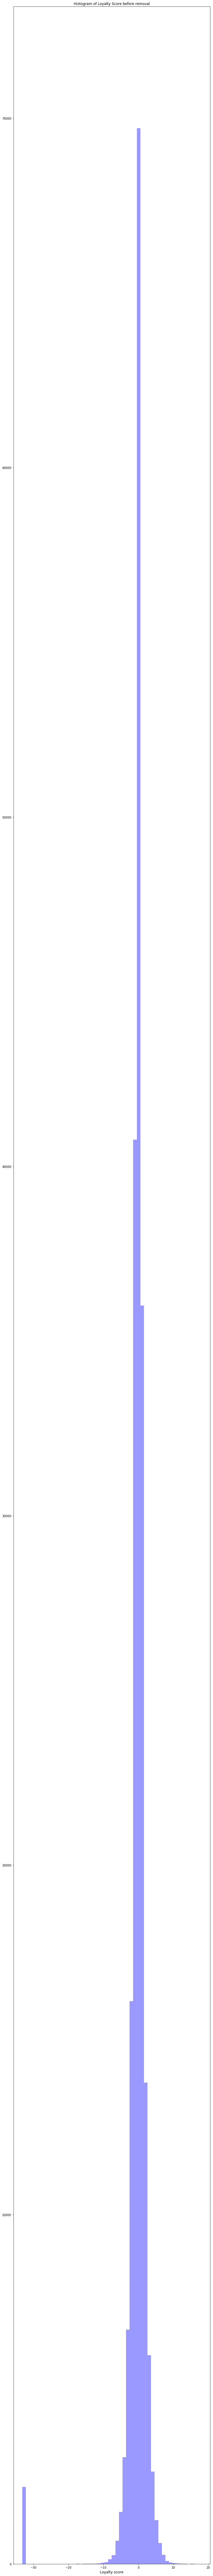

In [5]:
plt.figure(figsize=(12,160))
sns.distplot(target.values, bins=50, kde=False, color='blue')
plt.title('Histogram of Loyalty Score before removal')
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

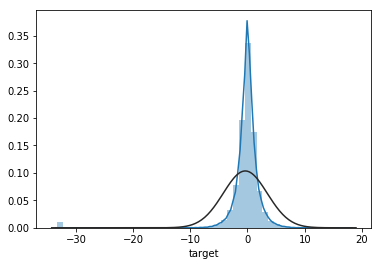

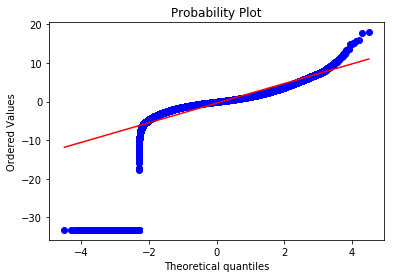

In [6]:
from scipy.stats import norm
from scipy import stats
sns.distplot(target, fit=norm)
fig = plt.figure()
res = stats.probplot(target, plot=plt)

In [7]:
#skewness and kurtosis
print("Skewness: %f" % pd.DataFrame(target).skew())
print("Kurtosis: %f" % pd.DataFrame(target).kurt())

Skewness: -6.720160
Kurtosis: 55.031783


In [8]:
min_target = min(value for value in target if value > -20)
min_target

-17.60814651

In [9]:
idx_between_20_30 = [value for value in target if value >= -30 and value <=-20]
len(idx_between_20_30)

0

In [10]:
idx_lessThan_30 = [value for value in target if value < -30]
len(idx_lessThan_30)

2207

In [11]:
# https://www.kaggle.com/nottold/naive-ensemble-model-ridge-lasso
class OutlierDetection(BaseEstimator):
    def __init__(self, alpha, dims, std, mean, median):
        self.alpha = alpha
        self.dims = dims
        self.std = std
        self.mean = mean
        self.median = median
    def fit(self, X):
        # std, mean, median = X.std(), X.mean(), X.median()
        X["outliers"] = 0
        for col in X.columns:
#             print(col)
            if not col == "outliers":
                # outlier_idx = (abs(X[col]) > (self.alpha * std[col] + mean[col]))
                outlier_idx = (np.abs(X[col]) > (self.alpha * self.std[col] + self.mean[col]))
                X.set_value(outlier_idx, "outliers", X[outlier_idx]["outliers"] + 1)
        outliers = X[X["outliers"] > self.dims]
        X.drop("outliers", axis=1, inplace=True)
        outlier_idx = outliers.index.tolist()
        # return outliers.index
        return set(list(range(X.shape[0]))) - set(outlier_idx), outlier_idx

In [12]:
target_df = pd.DataFrame(target)

outlier_removal = OutlierDetection(alpha=3, 
                                   dims=0, 
                                   std=target_df.std().astype('float'), 
                                   mean=target_df.mean().astype('float'), 
                                   median=target_df.median().astype('float'))
normal_idx, outlier_idx = outlier_removal.fit(target_df)
# samples = target_df.shape[0] - len(outlier)
# xtrain = xtrain.drop(outlier_index).reset_index(drop=True)
# y = y.drop(outlier_index).reset_index(drop=True)

In [13]:
train["outliers"] = 0
train.at[outlier_idx, "outliers"] = 1

In [14]:
train["outliers"].unique()

array([0, 1])

In [ ]:
with open('../input/train_test_target_with_target_v8.pkl', 'wb') as f:
    pickle.dump([train, target, test, normal_idx, outlier_idx], f)

In [ ]:
with open('../input/train_test_target_with_target_v8.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)

In [ ]:
# train.head()

In [ ]:
# list(train)

In [ ]:
# train.dtypes

In [ ]:
# categorical_feats

In [ ]:
# def standardizer(X):
# #     transformer = RobustScaler().fit(X) 
#     transformer = MinMaxScaler().fit(X) 
#     return transformer.transform(X)


# feat_list = [ 'elapsed_time',
#  'hist_transactions_count',
#  'hist_month_8_mean',
#  'hist_category_2_4_cross_16.0_mean',
#  'hist_month_9_mean',
#  'hist_category_1_3_cross_3_mean',
#  'hist_city_id_nunique',
#  'hist_month_lag_min',
#  'hist_month_lag_max',
#  'hist_dow_2_mean',
#  'hist_hour_22_mean',
#  'hist_month_3_mean',
#  'hist_purchase_amount_mean',
#  'hist_hour_5_mean',
#  'hist_category_1_4_cross_6_mean',
#  'hist_category_1_3_cross_6_mean',
#  'hist_hour_13_mean',
#  'hist_category_1_3_cross_8_mean',
#  'hist_category_1_3_cross_4_mean',
#  'hist_category_2_3_cross_11.0_mean',
#  'hist_category_2_4_cross_9.0_mean',
#  'hist_purchase_date_ptp',
#  'hist_purchase_date_min',
#  'hist_purchase_date_max',
#  'hist_category_1_3_cross_12_mean',
#  'hist_hour_18_mean',
#  'hist_category_3_2_mean',
#  'hist_category_2_3_cross_16.0_mean',
#  'hist_purchase_month_mean',
#  'hist_day_part_Morning_mean',
#  'hist_hour_11_mean',
#  'hist_category_2_2.0_mean',
#  'hist_month_6_mean',
#  'hist_category_2_4_cross_18.0_mean',
#  'hist_category_1_4_cross_4_mean',
#  'hist_hour_0_mean',
#  'hist_category_2_4_cross_11.0_mean',
#  'hist_category_3_4_cross_7_mean',
#  'hist_category_3_3_mean',
#  'hist_category_2_4_cross_20.0_mean',
#  'hist_category_2_3_cross_14.0_mean',
#  'hist_category_2_4_cross_7.0_mean',
#  'hist_month_12_mean',
#  'hist_category_1_4_cross_3_mean',
#  'hist_category_2_3_cross_27.0_mean',
#  'hist_day_part_Evening_mean',
#  'hist_month_10_mean',
#  'hist_state_id_nunique',
#  'hist_hour_6_mean',
#  'hist_hour_17_mean',
#  'hist_hour_20_mean',
#  'hist_category_2_3_cross_20.0_mean',
#  'hist_day_part_Afternoon_mean',
#  'hist_category_2_4_cross_8.0_mean',
#  'hist_dow_1_mean',
#  'hist_dow_5_mean',
#  'hist_category_2_1.0_mean',
#  'hist_dow_6_mean',
#  'hist_category_3_4_cross_5_mean',
#  'hist_hour_4_mean',
#  'hist_category_2_3_cross_10.0_mean',
#  'hist_dow_4_mean',
#  'hist_subsector_id_nunique',
#  'hist_category_3_4_cross_6_mean',
#  'hist_month_2_mean',
#  'hist_category_2_3_cross_7.0_mean',
#  'hist_hour_15_mean',
#  'hist_month_4_mean',
#  'hist_category_1_3_cross_9_mean',
#  'hist_category_2_3_cross_21.0_mean',
#  'hist_category_1_4_cross_8_mean',
#  'hist_hour_16_mean',
#  'hist_hour_23_mean',
#  'hist_category_2_5.0_mean',
#  'hist_hour_8_mean',
#  'hist_dow_0_mean',
#  'hist_category_2_4.0_mean',
#  'hist_category_2_3_cross_8.0_mean',
#  'hist_category_2_3_cross_24.0_mean',
#  'hist_dow_3_mean',
#  'hist_category_2_3.0_mean',
#  'hist_category_2_3_cross_22.0_mean',
#  'hist_hour_10_mean',
#  'hist_month_5_mean',
#  'hist_category_2_3_cross_30.0_mean',
#  'hist_category_2_3_cross_33.0_mean',
#  'hist_hour_21_mean',
#  'hist_category_3_4_cross_12_mean',
#  'hist_hour_14_mean',
#  'hist_category_2_4_cross_14.0_mean',
#  'hist_category_2_4_cross_10.0_mean',
#  'hist_hour_2_mean',
#  'hist_hour_12_mean',
#  'hist_month_11_mean',
#  'hist_category_2_3_cross_9.0_mean',
#  'hist_hour_9_mean',
#  'hist_hour_3_mean',
#  'hist_installments_mean',
#  'hist_hour_1_mean',
#  'hist_month_7_mean',
#  'hist_hour_19_mean',
#  'hist_category_3_4_cross_14_mean',
#  'hist_month_1_mean',
#  'hist_category_2_4_cross_22.0_mean',
#  'hist_hour_7_mean',
#  'hist_category_3_4_cross_10_mean',
#  'auth_transactions_count',
#  'auth_month_8_mean',
#  'auth_category_2_4_cross_16.0_mean',
#  'auth_month_9_mean',
#  'auth_category_1_3_cross_3_mean',
#  'auth_city_id_nunique',
#  'auth_month_lag_min',
#  'auth_month_lag_max',
#  'auth_dow_2_mean',
#  'auth_hour_22_mean',
#  'auth_month_3_mean',
#  'auth_purchase_amount_sum',
#  'auth_purchase_amount_mean',
#  'auth_purchase_amount_max',
#  'auth_purchase_amount_min',
#  'auth_purchase_amount_std',
#  'auth_hour_5_mean',
#  'auth_category_1_4_cross_6_mean',
#  'auth_category_1_3_cross_6_mean',
#  'auth_hour_13_mean',
#  'auth_category_1_3_cross_8_mean',
#  'auth_category_1_3_cross_4_mean',
#  'auth_category_2_4_cross_9.0_mean',
#  'auth_purchase_date_ptp',
#  'auth_purchase_date_min',
#  'auth_purchase_date_max',
#  'auth_category_1_3_cross_12_mean',
#  'auth_hour_18_mean',
#  'auth_category_2_3_cross_16.0_mean',
#  'auth_purchase_month_mean',
#  'auth_day_part_Morning_mean',
#  'auth_hour_11_mean',
#  'auth_month_6_mean',
#  'auth_category_2_4_cross_18.0_mean',
#  'auth_hour_0_mean',
#  'auth_category_2_4_cross_11.0_mean',
#  'auth_category_3_4_cross_7_mean',
#  'auth_category_3_3_mean',
#  'auth_category_2_4_cross_20.0_mean',
#  'auth_category_2_3_cross_14.0_mean',
#  'auth_category_2_4_cross_7.0_mean',
#  'auth_month_12_mean',
#  'auth_category_1_4_cross_3_mean',
#  'auth_category_2_3_cross_27.0_mean',
#  'auth_day_part_Evening_mean',
#  'auth_month_10_mean',
#  'auth_state_id_nunique',
#  'auth_hour_6_mean',
#  'auth_hour_17_mean',
#  'auth_hour_20_mean',
#  'auth_category_2_3_cross_20.0_mean',
#  'auth_day_part_Afternoon_mean',
#  'auth_dow_1_mean',
#  'auth_dow_5_mean',
#  'auth_category_2_1.0_mean',
#  'auth_dow_6_mean',
#  'auth_category_3_4_cross_5_mean',
#  'auth_hour_4_mean',
#  'auth_dow_4_mean',
#  'auth_subsector_id_nunique',
#  'auth_category_3_4_cross_6_mean',
#  'auth_merchant_id_nunique',
#  'auth_month_2_mean',
#  'auth_hour_15_mean',
#  'auth_month_4_mean',
#  'auth_category_1_3_cross_9_mean',
#  'auth_category_2_3_cross_21.0_mean',
#  'auth_category_1_4_cross_8_mean',
#  'auth_hour_16_mean',
#  'auth_hour_23_mean',
#  'auth_hour_8_mean',
#  'auth_dow_0_mean',
#  'auth_category_2_3_cross_24.0_mean',
#  'auth_dow_3_mean',
#  'auth_category_2_3_cross_22.0_mean',
#  'auth_hour_10_mean',
#  'auth_month_5_mean',
#  'auth_category_2_3_cross_30.0_mean',
#  'auth_category_2_3_cross_33.0_mean',
#  'auth_hour_21_mean',
#  'auth_category_3_4_cross_12_mean',
#  'auth_hour_14_mean',
#  'auth_category_2_4_cross_14.0_mean',
#  'auth_category_2_4_cross_10.0_mean',
#  'auth_hour_2_mean',
#  'auth_hour_12_mean',
#  'auth_month_11_mean',
#  'auth_category_2_3_cross_9.0_mean',
#  'auth_hour_9_mean',
#  'auth_hour_3_mean',
#  'auth_installments_sum',
#  'auth_installments_mean',
#  'auth_installments_max',
#  'auth_installments_min',
#  'auth_installments_std',
#  'auth_hour_1_mean',
#  'auth_month_7_mean',
#  'auth_hour_19_mean',
#  'auth_category_3_4_cross_14_mean',
#  'auth_month_1_mean',
#  'auth_category_2_4_cross_22.0_mean',
#  'auth_hour_7_mean',
#  'auth_category_3_4_cross_10_mean',
#  'new_transactions_count',
#  'new_month_8_mean',
#  'new_category_2_4_cross_16.0_mean',
#  'new_month_9_mean',
#  'new_city_id_nunique',
#  'new_month_lag_min',
#  'new_month_lag_max',
#  'new_dow_2_mean',
#  'new_hour_22_mean',
#  'new_month_3_mean',
#  'new_purchase_amount_sum',
#  'new_purchase_amount_mean',
#  'new_purchase_amount_max',
#  'new_purchase_amount_min',
#  'new_hour_5_mean',
#  'new_category_1_4_cross_6_mean',
#  'new_category_1_3_cross_6_mean',
#  'new_hour_13_mean',
#  'new_category_1_3_cross_8_mean',
#  'new_category_1_3_cross_4_mean',
#  'new_category_2_4_cross_9.0_mean',
#  'new_purchase_date_ptp',
#  'new_category_1_3_cross_12_mean',
#  'new_hour_18_mean',
#  'new_category_2_3_cross_16.0_mean',
#  'new_purchase_month_mean',
#  'new_day_part_Morning_mean',
#  'new_hour_11_mean',
#  'new_category_2_2.0_mean',
#  'new_month_6_mean',
#  'new_category_2_4_cross_18.0_mean',
#  'new_category_1_4_cross_4_mean',
#  'new_hour_0_mean',
#  'new_category_2_4_cross_11.0_mean',
#  'new_category_3_4_cross_7_mean',
#  'new_category_3_3_mean',
#  'new_category_2_4_cross_20.0_mean',
#  'new_category_2_3_cross_14.0_mean',
#  'new_category_2_4_cross_7.0_mean',
#  'new_month_12_mean',
#  'new_category_1_4_cross_3_mean',
#  'new_category_2_3_cross_27.0_mean',
#  'new_day_part_Evening_mean',
#  'new_month_10_mean',
#  'new_state_id_nunique',
#  'new_hour_6_mean',
#  'new_hour_17_mean',
#  'new_hour_20_mean',
#  'new_category_2_3_cross_20.0_mean',
#  'new_day_part_Afternoon_mean',
#  'new_category_2_4_cross_8.0_mean',
#  'new_dow_1_mean',
#  'new_dow_5_mean',
#  'new_category_2_1.0_mean',
#  'new_dow_6_mean',
#  'new_category_3_4_cross_5_mean',
#  'new_hour_4_mean',
#  'new_category_2_3_cross_12.0_mean',
#  'new_dow_4_mean',
#  'new_subsector_id_nunique',
#  'new_category_3_4_cross_6_mean',
#  'new_month_2_mean',
#  'new_hour_15_mean',
#  'new_month_4_mean',
#  'new_category_1_3_cross_9_mean',
#  'new_category_2_3_cross_21.0_mean',
#  'new_category_1_4_cross_8_mean',
#  'new_hour_16_mean',
#  'new_hour_23_mean',
#  'new_hour_8_mean',
#  'new_dow_0_mean',
#  'new_category_2_3_cross_24.0_mean',
#  'new_dow_3_mean',
#  'new_category_2_3_cross_22.0_mean',
#  'new_hour_10_mean',
#  'new_month_5_mean',
#  'new_category_2_3_cross_30.0_mean',
#  'new_category_2_3_cross_33.0_mean',
#  'new_hour_21_mean',
#  'new_category_3_4_cross_12_mean',
#  'new_hour_14_mean',
#  'new_category_2_4_cross_14.0_mean',
#  'new_category_2_4_cross_10.0_mean',
#  'new_hour_2_mean',
#  'new_hour_12_mean',
#  'new_month_11_mean',
#  'new_hour_9_mean',
#  'new_hour_3_mean',
#  'new_installments_sum',
#  'new_installments_mean',
#  'new_installments_max',
#  'new_installments_min',
#  'new_installments_std',
#  'new_hour_1_mean',
#  'new_month_7_mean',
#  'new_hour_19_mean',
#  'new_category_3_4_cross_14_mean',
#  'new_month_1_mean',
#  'new_category_2_4_cross_22.0_mean',
#  'new_hour_7_mean',
#  'new_category_3_4_cross_10_mean',
#  'month_lag_mean',
#  'month_lag_std',
#  'installments_count_mean',
#  'installments_count_std',
#  'installments_sum_mean',
#  'authorized_flag_mean',
#  'authorized_flag_std']
# train[feat_list] = standardizer(train[feat_list])
# test[feat_list] = standardizer(test[feat_list])

## Step 1: Training Model Without Outliers for 5 fold (n_repeats = 1)

In [15]:
df_train = train[train['outliers'] == 0]
df_target = target[normal_idx]
features = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','outliers']]
categorical_feats = [c for c in features if 'feature_' in c]

In [16]:
# df_train.shape, df_target.shape

In [17]:
def lgbm_regression_train(train, target, test, param, features, categorical_feats):
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    return predictions, oof, feature_importance_df

In [44]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01, #default: 0.005 ()   /   0.005(), 0.01 (), 0.05 ()
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": -1,
         "verbosity": -1}

normal_predictions, oof, feature_importance_df = lgbm_regression_train(df_train, 
                                                df_target, 
                                                test, 
                                                param, 
                                                features, 
                                                categorical_feats)

In [20]:
model_without_outliers = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers["target"] = normal_predictions

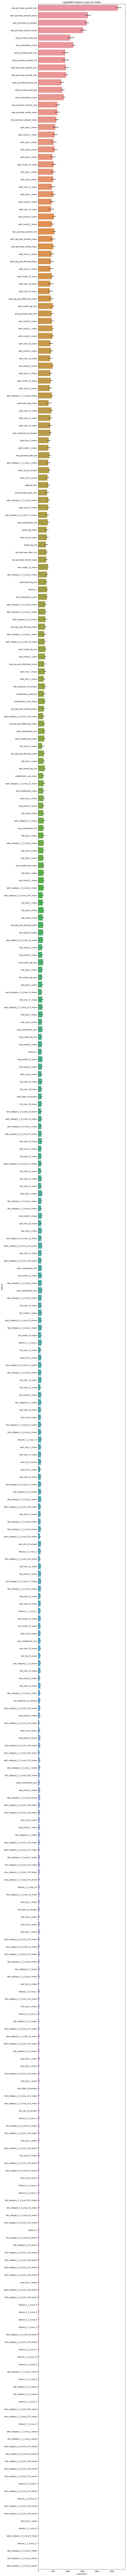

In [21]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,200))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('../img/lgbm_importances.png')

In [24]:
best_features.head()

,feature,importance,fold
0,feature_1,333,1
1,feature_2,93,1
2,feature_3,19,1
3,elapsed_time,308,1
4,hist_transactions_count,320,1


In [39]:
feat_importance_sorted = best_features.groupby('feature').importance.agg(['mean']).reset_index().sort_values('mean', ascending=False).reset_index()
selected_feat = feat_importance_sorted["feature"][0:175]

## Part 2: Training Model For Outliers Classification for 5 fold (n_repeats = 1)

In [ ]:
def lgbm_classification_train(df_train, target, df_test, param, features, categorical_feats):
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()

    start = time.time()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits
        
    print("CV score: {:<8.5f}".format(log_loss(target, oof)))

    return predictions, oof

In [ ]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

with open('../input/train_test_target_with_target.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)

target = train['outliers']
del train['outliers']
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]
outlier_label, oof_class = lgbm_classification_train(train, target, test, param, features, categorical_feats)

In [ ]:
df_outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
df_outlier_prob["target"] = outlier_label
df_outlier_prob.head()

## Part 3: Combining Submission for 5 fold (n_repeats = 1)

In [ ]:
outlier_id = pd.DataFrame(\
                          df_outlier_prob.sort_values(by='target',
                                                      ascending = False)
                          .head(25000)['card_id'])

In [ ]:
best_submission = pd.read_csv('../result/Blend2_v2.csv')

In [ ]:
print(best_submission.shape[0])
best_submission.head()

In [ ]:
print(outlier_id.shape[0])
most_likely_liers = best_submission.merge(outlier_id,how='right')
most_likely_liers.head()

In [ ]:
%%time
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target']\
    = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

In [ ]:
# model_without_outliers.to_csv("../result/Blend2_v3.csv", index=False)

In [ ]:
# print(normal_predictions.shape)
# normal_predictions[0:20]

In [ ]:
# print(model_without_outliers.shape)
# model_without_outliers[0:20]

## Step 4: Training Model Without Outliers for 5 fold (n_repeats = 2)

In [ ]:
def lgbm_regression_train_n_repeats_2(train, target, test, param, features, categorical_feats):
    folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)
    oof_lgb = np.zeros(len(train))
    predictions_lgb = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        num_round = 11000
        clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
        oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

    print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))
    return predictions_lgb, oof_lgb

In [ ]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.005,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

with open('../input/train_test_target_with_target.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)

df_train = train[train['outliers'] == 0]
df_target = target[normal_idx]
features = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','outliers']]
categorical_feats = [c for c in features if 'feature_' in c]
    
normal_predictions_n_repeats_2, oof_n_repeats_2 = lgbm_regression_train_n_repeats_2(df_train, 
                                                                                    df_target, 
                                                                                    test, 
                                                                                    lgbparam, 
                                                                                    features, 
                                                                                    categorical_feats)

In [ ]:
model_without_outliers_n_repeats_2 = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers_n_repeats_2["target"] = normal_predictions_n_repeats_2

## Part 5: Training Model For Outliers Classification for 5 fold (n_repeats = 2)

In [ ]:
def lgbm_classification_train_n_repeats_2(df_train, target, df_test, param, features, categorical_feats):
    folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=15)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()

    start = time.time()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / (5 * 2)
        
    print("CV score: {:<8.5f}".format(log_loss(target, oof)))

    return predictions, oof

In [ ]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

with open('../input/train_test_target_with_target.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)

target = train['outliers']
del train['outliers']
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]
outlier_label_n_repeats_2, oof_class_n_repeats_2 = lgbm_classification_train_n_repeats_2(train, 
                                                                                         target, 
                                                                                         test, 
                                                                                         param, 
                                                                                         features, 
                                                                                         categorical_feats)

In [ ]:
df_outlier_prob_n_repeats_2 = pd.DataFrame({"card_id":test["card_id"].values})
df_outlier_prob_n_repeats_2["target"] = outlier_label_n_repeats_2
df_outlier_prob_n_repeats_2.head()

## Part 6: Combining Submission for 5 fold (n_repeats = 2)


In [ ]:
outlier_id_n_repeats_2 = pd.DataFrame(\
                                      df_outlier_prob_n_repeats_2.sort_values(by='target',
                                                                              ascending = False)
                                      .head(25000)['card_id'])

In [ ]:
best_submission = pd.read_csv('../result/Blend2_v2.csv')

In [ ]:
print(best_submission.shape[0])
best_submission.head()

In [ ]:
print(outlier_id.shape[0])
most_likely_liers_n_repeats_2 = best_submission.merge(outlier_id_n_repeats_2,how='right')
most_likely_liers_n_repeats_2.head()

In [ ]:
%%time
for card_id in most_likely_liers_n_repeats_2['card_id']:
    model_without_outliers_n_repeats_2.loc[model_without_outliers_n_repeats_2['card_id']==card_id,'target']\
    = most_likely_liers_n_repeats_2.loc[most_likely_liers_n_repeats_2['card_id']==card_id,'target'].values

In [ ]:
model_without_outliers_n_repeats_2.to_csv("../result/Blend2_v6_n_repeats_2.csv", index=False)

In [ ]:
len(model_without_outliers['target'].values.tolist())

In [ ]:
len(model_without_outliers_n_repeats_2['target'].values.tolist())

In [ ]:
oof.shape

In [ ]:
oof_n_repeats_2.shape

In [ ]:
target.shape, len(normal_idx), len(outlier_idx)

## Part 7: Stacking

In [ ]:
print(type(target))
print(type(oof))
print(type(oof_normal_final))

In [ ]:
len(outlier_idx), len(outlier_idx)

In [ ]:
# oof_normal_final

In [ ]:
with open('../input/train_test_target_with_target.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)
    
oof_normal_final = pd.Series(np.zeros(len(target)))
oof_normal_final[normal_idx] = oof
oof_normal_final[outlier_idx] = outlier_idx

oof_n_repeats_2_final = pd.Series(np.zeros(len(target)))
oof_n_repeats_2_final[normal_idx] = oof_n_repeats_2
oof_n_repeats_2_final[outlier_idx] = outlier_idx

In [ ]:
train_stack = np.vstack([oof_normal_final,oof_n_repeats_2_final]).transpose()
test_stack = np.vstack([model_without_outliers['target'].values.tolist(),
                        model_without_outliers_n_repeats_2['target'].values.tolist()]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

In [ ]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('../result/Bayesian_Ridge_Stacking.csv', index=False)

In [ ]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample1 = pd.read_csv("../result/3.695.csv")
sample2 = pd.read_csv("../result/combining_submission (1).csv")
sample_submission['target'] = model_without_outliers['target'] * 0.5 + model_without_outliers_n_repeats_2['target'] * 0.5
sample_submission.to_csv("../result/Blend1_v8.csv", index = False)
sample_submission['target'] = sample_submission['target'] * 0.2 + sample1['target'] * 0.2 + sample2['target'] * 0.6
sample_submission.to_csv('../result/Blend2_v8.csv', index=False)

`Blend2_v6.csv` got the best submission score so far - 3.691.